In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

#Preprocess with Data Augmentation

In [2]:
# Define paths
base_dir = r'C:\Users\nayer\pneumonia-detection\data\chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Data generators with augmentation and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,        # Randomly rotate images by up to 20 degrees
    zoom_range=0.2,          # Randomly zoom in/out by up to 20%
    horizontal_flip=True,     # Randomly flip images horizontally
    brightness_range=[0.9, 1.1],  # Adjust brightness by 10%
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False  # Keep validation data order consistent
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#Use the Same CNN Architecture

In [3]:
# Build the same CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

#Train the Model with Augmented Data

In [4]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

# Save the model
model.save(r'C:\Users\nayer\pneumonia-detection\models\cnn_augmented_model.h5')

Epoch 1/20
131/131 [==============================] - 496s 4s/step - loss: 0.4955 - accuracy: 0.7601 - val_loss: 0.3071 - val_accuracy: 0.8629
Epoch 2/20
131/131 [==============================] - 519s 4s/step - loss: 0.2790 - accuracy: 0.8835 - val_loss: 0.2584 - val_accuracy: 0.8945
Epoch 3/20
131/131 [==============================] - 180s 1s/step - loss: 0.2566 - accuracy: 0.8994 - val_loss: 0.2582 - val_accuracy: 0.8811
Epoch 4/20
131/131 [==============================] - 154s 1s/step - loss: 0.2207 - accuracy: 0.9111 - val_loss: 0.2242 - val_accuracy: 0.9089
Epoch 5/20
131/131 [==============================] - 227s 2s/step - loss: 0.2059 - accuracy: 0.9214 - val_loss: 0.2312 - val_accuracy: 0.9041
Epoch 6/20
131/131 [==============================] - 335s 3s/step - loss: 0.1923 - accuracy: 0.9279 - val_loss: 0.2718 - val_accuracy: 0.8849
Epoch 7/20
131/131 [==============================] - 155s 1s/step - loss: 0.1696 - accuracy: 0.9358 - val_loss: 0.2015 - val_accuracy: 0.9147

#Evaluate the Augmented Model

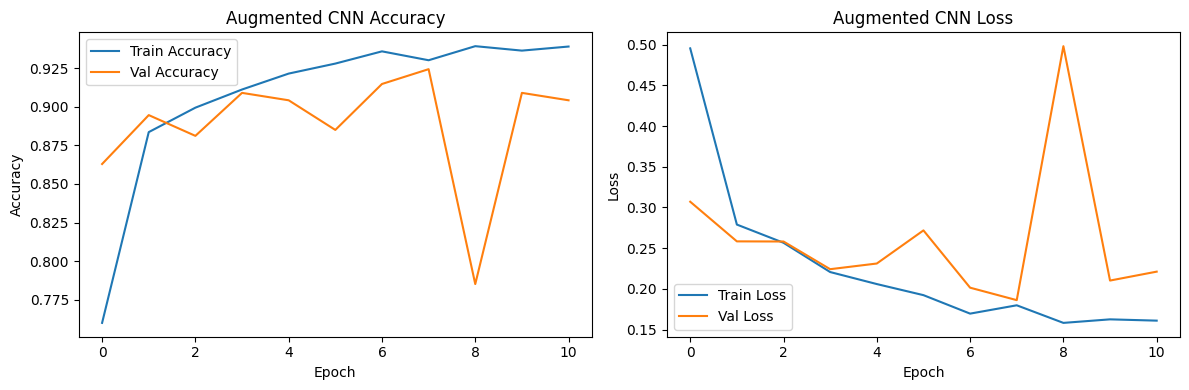

20/20 [==============================] - 5s 250ms/step - loss: 0.3234 - accuracy: 0.8878
Test Accuracy: 0.8878
20/20 [==============================] - 5s 244ms/step
Confusion Matrix:
 [[175  59]
 [ 11 379]]
Classification Report:
               precision    recall  f1-score   support

      Normal       0.94      0.75      0.83       234
   Pneumonia       0.87      0.97      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.86      0.87       624
weighted avg       0.89      0.89      0.88       624



<Figure size 640x480 with 0 Axes>

In [6]:


# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Augmented CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Augmented CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Save plot
plt.savefig(r'C:\Users\nayer\pneumonia-detection\docs\augmented_cnn_plot.png')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

# Confusion matrix and classification report
test_generator.reset()
y_pred = (model.predict(test_generator) > 0.5).astype(int)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))